# Steel Defect Detection - Prediction Visualization

This notebook loads a trained model and visualizes predictions on validation images.

**Features:**
- Load checkpoint from any training run
- Visualize validation images for a specific fold
- Compare predictions vs ground truth
- Show per-image metrics (Dice, IoU)
- Analyze model performance on different defect types

## 1. Configuration

In [1]:
# ===== USER CONFIGURATION =====
# Path to your checkpoint file
CHECKPOINT_PATH = "outputs_20260111_205115_baseline/fold_0/best_model.pth"

# Which fold to visualize (should match checkpoint)
FOLD = 0

# Number of images to visualize
NUM_IMAGES = 5

# Visualization settings
FIGSIZE_PER_IMAGE = (15, 8)  # Width, height for each image row
THRESHOLD = 0.5              # Prediction threshold
MIN_SIZE = 3500              # Minimum component size

# Filter settings (set to None to see all images)
SHOW_ONLY_WITH_DEFECTS = False  # If True, only show images with defects
SHOW_SPECIFIC_CLASS = None       # Set to 0, 1, 2, or 3 to filter by class, None for all
# ==============================

## 2. Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from outputs_20260111_205115_baseline import config
from model import get_model
from dataset import prepare_trainval_dataframe, SteelDataset
from losses import post_process

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.2.0+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3090


## 3. Load Model

In [3]:
config.MODEL_ARCH, config.ENCODER

('unet', 'resnet18')

In [4]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load checkpoint
print(f"\nLoading checkpoint: {CHECKPOINT_PATH}")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

# Get model configuration from checkpoint or config
model = get_model(
    arch=config.MODEL_ARCH,
    encoder=config.ENCODER,
    encoder_weights=None,  # We're loading trained weights
    num_classes=config.NUM_CLASSES,
    activation=None
)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"  Architecture: {config.MODEL_ARCH}")
print(f"  Encoder: {config.ENCODER}")
print(f"  Best Dice: {checkpoint.get('best_dice', 'N/A')}")
print(f"  Best Loss: {checkpoint.get('best_loss', 'N/A')}")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")

Using device: cuda:0

Loading checkpoint: outputs_20260111_205115_baseline/fold_0/best_model.pth
✓ Model loaded successfully
  Architecture: unet
  Encoder: resnet18
  Best Dice: 0.7482426734927717
  Best Loss: 0.011056242591643102
  Epoch: 21


## 4. Load Validation Data

In [5]:
# Prepare dataframe
df = prepare_trainval_dataframe(
    config.TRAIN_CSV, 
    n_folds=config.NUM_FOLDS, 
    seed=config.SEED, 
    train_images_dir=config.TRAIN_IMAGES_DIR
)

# Get validation data for the specified fold
val_df = df[df['fold'] == FOLD].copy()
print(f"Validation set for fold {FOLD}: {len(val_df)} images")

# Create dataset and dataloader
val_dataset = SteelDataset(
    val_df, 
    config.TRAIN_IMAGES_DIR, 
    config.MEAN, 
    config.STD, 
    phase='val'
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,  # Process one image at a time for visualization
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"✓ Data loaded successfully")

Validation set for fold 0: 2514 images
✓ Data loaded successfully


## 5. Utility Functions

In [6]:
def denormalize_image(image, mean, std):
    """Denormalize image for visualization"""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def compute_dice_per_class(pred, target, num_classes=4, eps=1e-6):
    """Compute Dice score per class"""
    dice_scores = []
    for c in range(num_classes):
        pred_c = pred[c]
        target_c = target[c]
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        
        if union == 0:
            dice = 1.0  # Both empty
        else:
            dice = (2 * intersection + eps) / (union + eps)
        
        dice_scores.append(dice)
    
    return dice_scores

def overlay_mask_on_image(image, mask, color, alpha=0.4):
    """Overlay colored mask on image"""
    overlay = image.copy()
    mask_bool = mask > 0.5
    overlay[mask_bool] = overlay[mask_bool] * (1 - alpha) + np.array(color) * alpha
    return overlay

print("✓ Utility functions defined")

✓ Utility functions defined


## 6. Generate and Visualize Predictions

Generating and visualizing predictions...

Look for yellow area in the picture - they are the true positive



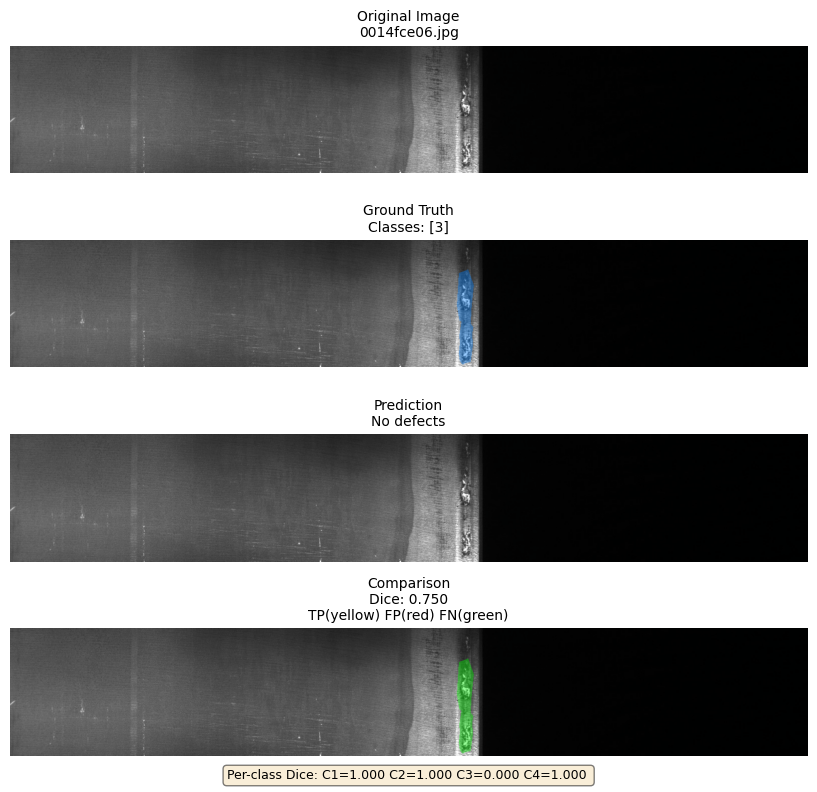

Image 1/5: 0014fce06.jpg
  Mean Dice: 0.7500
  Per-class: C1=1.000, C2=1.000, C3=0.000, C4=1.000



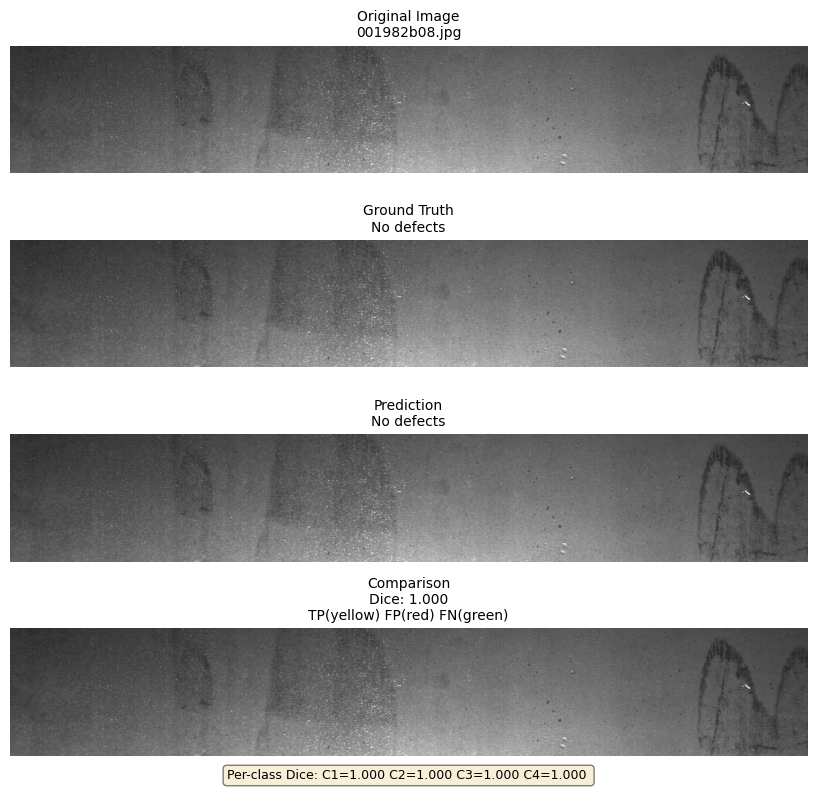

Image 2/5: 001982b08.jpg
  Mean Dice: 1.0000
  Per-class: C1=1.000, C2=1.000, C3=1.000, C4=1.000



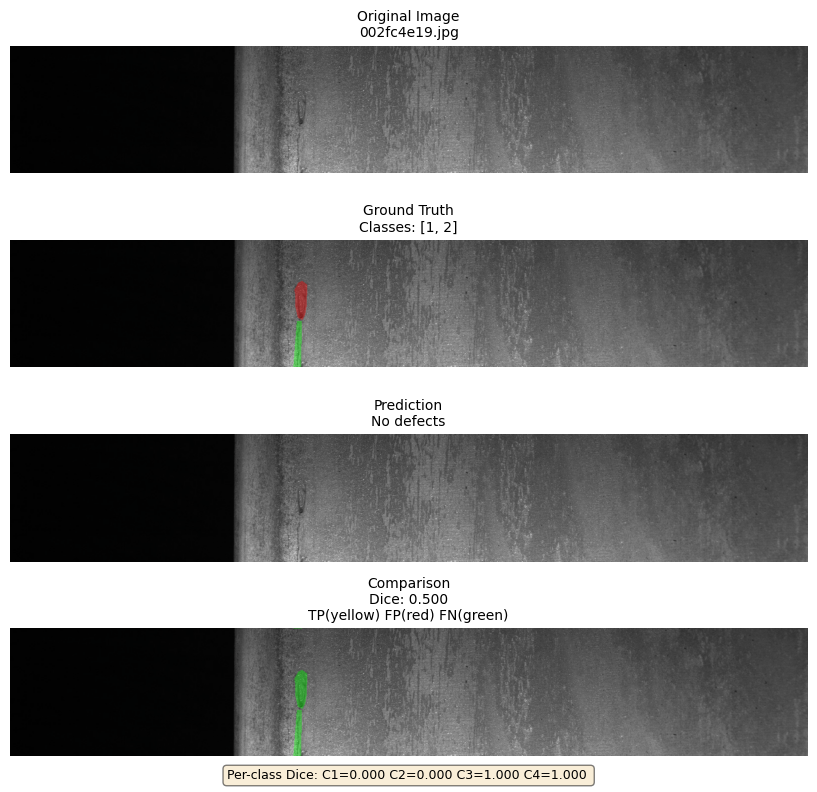

Image 3/5: 002fc4e19.jpg
  Mean Dice: 0.5000
  Per-class: C1=0.000, C2=0.000, C3=1.000, C4=1.000



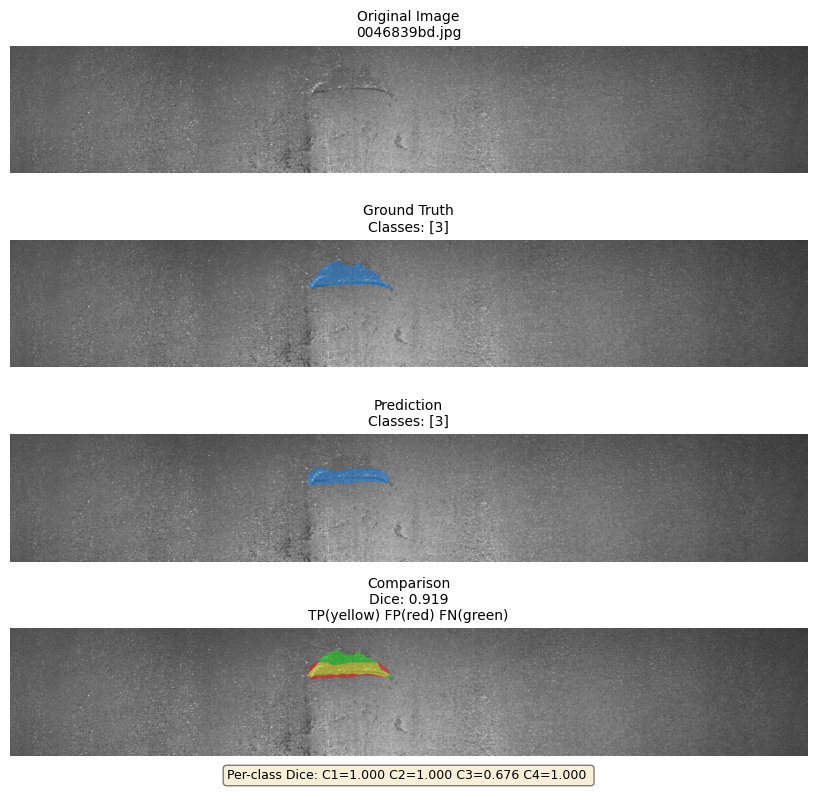

Image 4/5: 0046839bd.jpg
  Mean Dice: 0.9190
  Per-class: C1=1.000, C2=1.000, C3=0.676, C4=1.000



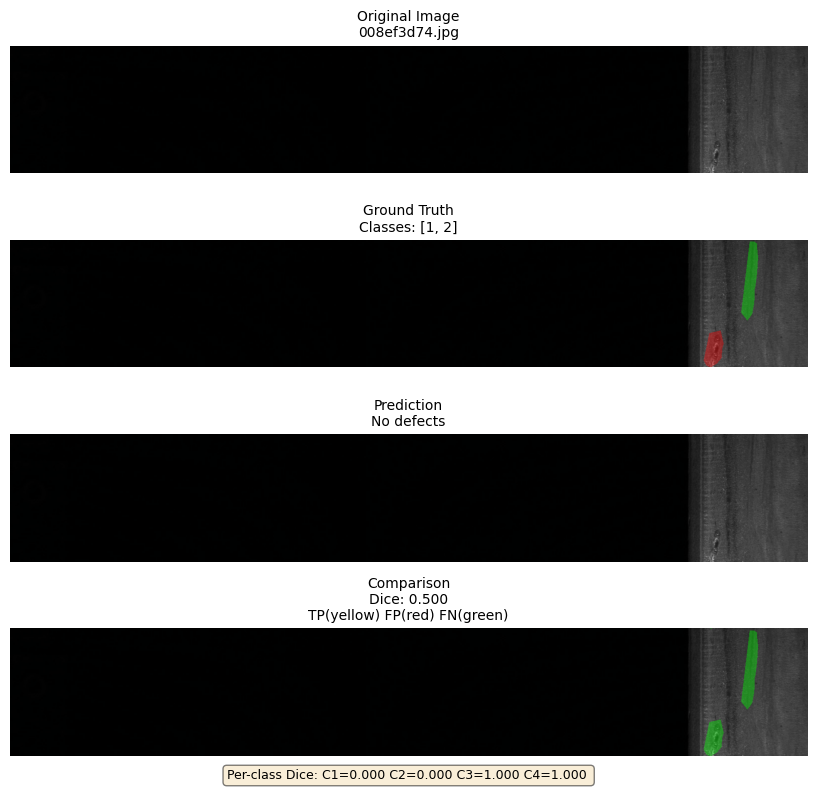

Image 5/5: 008ef3d74.jpg
  Mean Dice: 0.5000
  Per-class: C1=0.000, C2=0.000, C3=1.000, C4=1.000


✓ Visualized 5 images


In [7]:
# Colors for each defect class (RGB, 0-1 range)
CLASS_COLORS = [
    (1.0, 0.0, 0.0),  # Class 1: Red
    (0.0, 1.0, 0.0),  # Class 2: Green
    (0.0, 0.5, 1.0),  # Class 3: Blue
    (1.0, 1.0, 0.0),  # Class 4: Yellow
]

results = []
num_visualized = 0

print("Generating and visualizing predictions...\n")
print("Look for yellow area in the picture - they are the true positive\n")

with torch.no_grad():
    for idx, (image, mask, image_id) in enumerate(val_loader):
        if num_visualized >= NUM_IMAGES:
            break
        
        # Filter if needed
        if SHOW_ONLY_WITH_DEFECTS and mask.sum() == 0:
            continue
        
        if SHOW_SPECIFIC_CLASS is not None and mask[0, SHOW_SPECIFIC_CLASS].sum() == 0:
            continue
        
        # Run inference
        image_gpu = image.to(device)
        output = model(image_gpu)
        prob = torch.sigmoid(output).cpu().numpy()[0]  # [4, H, W]
        
        # Post-process predictions
        pred_masks = []
        for c in range(config.NUM_CLASSES):
            pred_c, _ = post_process(prob[c], THRESHOLD, MIN_SIZE)
            pred_masks.append(pred_c)
        
        # Get numpy arrays
        image_np = image.numpy()[0]  # [3, H, W]
        mask_np = mask.numpy()[0]    # [4, H, W]
        pred_np = np.stack(pred_masks, axis=0)  # [4, H, W]
        
        # Denormalize image
        image_display = denormalize_image(image_np, config.MEAN, config.STD)
        image_display = np.transpose(image_display, (1, 2, 0))  # [H, W, 3]
        
        # Compute metrics
        dice_scores = compute_dice_per_class(pred_np, mask_np)
        mean_dice = np.mean(dice_scores)
        
        # Create visualization
        fig, axes = plt.subplots(4, 1, figsize=FIGSIZE_PER_IMAGE)
        
        # 1. Original image
        axes[0].imshow(image_display)
        axes[0].set_title(f'Original Image\n{image_id[0]}', fontsize=10)
        axes[0].axis('off')
        
        # 2. Ground truth
        gt_overlay = image_display.copy()
        for c in range(config.NUM_CLASSES):
            if mask_np[c].sum() > 0:
                gt_overlay = overlay_mask_on_image(gt_overlay, mask_np[c], CLASS_COLORS[c], alpha=0.4)
        
        axes[1].imshow(gt_overlay)
        gt_classes = [c+1 for c in range(config.NUM_CLASSES) if mask_np[c].sum() > 0]
        gt_text = f"Classes: {gt_classes}" if gt_classes else "No defects"
        axes[1].set_title(f'Ground Truth\n{gt_text}', fontsize=10)
        axes[1].axis('off')
        
        # 3. Prediction
        pred_overlay = image_display.copy()
        for c in range(config.NUM_CLASSES):
            if pred_np[c].sum() > 0:
                pred_overlay = overlay_mask_on_image(pred_overlay, pred_np[c], CLASS_COLORS[c], alpha=0.4)
        
        axes[2].imshow(pred_overlay)
        pred_classes = [c+1 for c in range(config.NUM_CLASSES) if pred_np[c].sum() > 0]
        pred_text = f"Classes: {pred_classes}" if pred_classes else "No defects"
        axes[2].set_title(f'Prediction\n{pred_text}', fontsize=10)
        axes[2].axis('off')
        
        # 4. Comparison
        comparison = np.zeros_like(image_display)
        gt_any = mask_np.sum(axis=0) > 0
        pred_any = pred_np.sum(axis=0) > 0
        
        tp = gt_any & pred_any
        fp = (~gt_any) & pred_any
        fn = gt_any & (~pred_any)
        
        comparison[tp] = [1, 1, 0]  # Yellow
        comparison[fp] = [1, 0, 0]  # Red
        comparison[fn] = [0, 1, 0]  # Green
        
        comparison_overlay = image_display.copy()
        comparison_overlay[tp] = comparison_overlay[tp] * 0.6 + comparison[tp] * 0.4
        comparison_overlay[fp] = comparison_overlay[fp] * 0.6 + comparison[fp] * 0.4
        comparison_overlay[fn] = comparison_overlay[fn] * 0.6 + comparison[fn] * 0.4
        
        axes[3].imshow(comparison_overlay)
        axes[3].set_title(f'Comparison\nDice: {mean_dice:.3f}\nTP(yellow) FP(red) FN(green)', fontsize=10)
        axes[3].axis('off')
        
        # Add per-class metrics
        metrics_text = "Per-class Dice: "
        for c in range(config.NUM_CLASSES):
            metrics_text += f"C{c+1}={dice_scores[c]:.3f} "
        
        fig.text(0.5, 0.02, metrics_text, ha='center', fontsize=9, 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.show()
        
        print(f"Image {num_visualized+1}/{NUM_IMAGES}: {image_id[0]}")
        print(f"  Mean Dice: {mean_dice:.4f}")
        print(f"  Per-class: {', '.join([f'C{i+1}={d:.3f}' for i, d in enumerate(dice_scores)])}")
        print()
        
        results.append({
            'image_id': image_id[0],
            'dice_scores': dice_scores,
            'mean_dice': mean_dice
        })
        
        num_visualized += 1

print(f"\n✓ Visualized {num_visualized} images")

## 7. Summary Statistics

SUMMARY STATISTICS
Number of images: 5
Mean Dice: 0.7338 ± 0.2072
Median Dice: 0.7500
Min Dice: 0.5000
Max Dice: 1.0000

Per-class Dice scores:
  Class 1: 0.6000 ± 0.4899
  Class 2: 0.6000 ± 0.4899
  Class 3: 0.7352 ± 0.3884
  Class 4: 1.0000 ± 0.0000


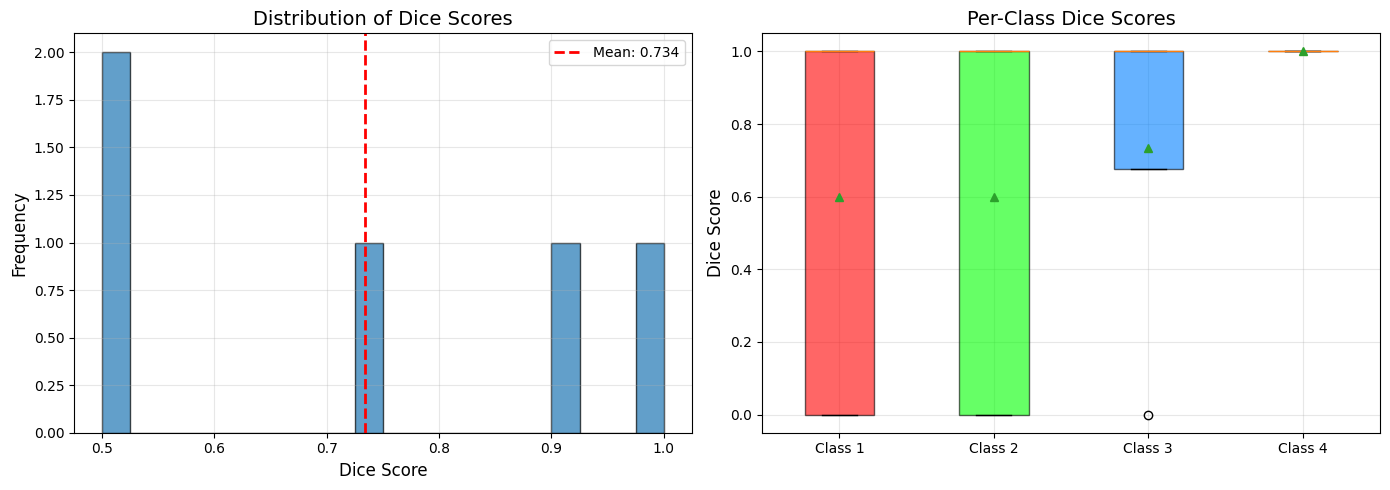


✓ Visualization complete!


In [8]:
if len(results) > 0:
    all_dice = [r['mean_dice'] for r in results]
    per_class_dice = [[r['dice_scores'][c] for r in results] for c in range(config.NUM_CLASSES)]
    
    print("="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Number of images: {len(results)}")
    print(f"Mean Dice: {np.mean(all_dice):.4f} ± {np.std(all_dice):.4f}")
    print(f"Median Dice: {np.median(all_dice):.4f}")
    print(f"Min Dice: {np.min(all_dice):.4f}")
    print(f"Max Dice: {np.max(all_dice):.4f}")
    print()
    print("Per-class Dice scores:")
    for c in range(config.NUM_CLASSES):
        print(f"  Class {c+1}: {np.mean(per_class_dice[c]):.4f} ± {np.std(per_class_dice[c]):.4f}")
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(all_dice, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(all_dice), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(all_dice):.3f}')
    axes[0].set_xlabel('Dice Score', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Dice Scores', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    box_data = [per_class_dice[c] for c in range(config.NUM_CLASSES)]
    bp = axes[1].boxplot(box_data, labels=[f'Class {c+1}' for c in range(config.NUM_CLASSES)],
                          patch_artist=True, showmeans=True)
    
    for patch, color in zip(bp['boxes'], CLASS_COLORS):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[1].set_ylabel('Dice Score', fontsize=12)
    axes[1].set_title('Per-Class Dice Scores', fontsize=14)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete!")
else:
    print("No images were visualized. Check your filter settings.")